- The notebook should contain your analysis and code. Please structure it into the following 4 sections

1. Motivation
What is your dataset?
Why did you choose this/these particular dataset(s)?
What was your goal for the end user's experience?

2. Basic stats. Let's understand the dataset better
Write about your choices in data cleaning and preprocessing
Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

3. Tools, theory and analysis. Describe the process of theory to insight
Talk about how you've worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
How did you use the tools to understand your dataset?

4. Discussion. Think critically about your creation
What went well?,
What is still missing? What could be improved?, Why?

5. Contributions. Who did what?
You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That’s what you should explain).

It is not OK simply to write "All group members contributed equally".

Some additional notes:
Make sure that you use references when they're needed and follow academic standards.

**I envision Part 3**: Tools, theory and analysis as the central part of the assignment, where you basically go through the steps in the analysis. So the structure of this part would be something like

1. Explain the overall idea
2. Analysis step 1
 - explain what you're interested in
 - explain the tool
 - apply the tool
 - discuss the outcome
2. Analysis step 2
 - explain what you're interested in
 - explain the tool
 - apply the tool
 - discuss the outcome
3. Analysis step 3,
... and so on until the analysis is done

## 1. Motivation

The Final Fantasy series had an incredible effect on the gaming world. Developed by Square Enix and released for the Nintendo Entertainment System (NES) in 1987, the game was considered an outlier at the time: games had simplistic plots and little to no character development. For this reason, the game was named "Final Fantasy," for the game's director thought it would be a failure for being a strange game at the time and would end his career. Nonetheless, history differed from expectations. Known for its rich lore, deep interactions between characters, and outstanding music, the series changed the role-playing genre forever. The Final Fantasy series became an international hit, selling more than 164 million units worldwide as of October 2021.

Out of all the 95 Final Fantasy games, we chose Final Fantasy XIV for the following reasons:
* It is the latest massive multiplayer online role-playing game, which has a relatively large number of characters, clans, and races.
* The wiki is well documented and detailed.
* Non-linear storyline, an interesting contrast to the Zelda network.

The final goal of this project is to understand the game's characters and world better through network and text analysis,  comprehend how the characters are related to each other, and see the importance of the characters in their respective communities.


## 2. Data

We analyzed two datasets for Final Fantasy XIV:

**1. The fan wiki of Final Fantasy XIV**

The [Final Fantasy XIV](https://finalfantasy.fandom.com/wiki/Final_Fantasy_XIV_characters)'s wiki was used to download all characters' descriptions and attributes. 

The data was extracted using the fandom wiki's API and stored in JSON. Regular expressions were utilized to extract the description of each character along with the attributes of interest: race and affiliation. Other attributes were also extracted: gender, age, and occupation.

**2. The game's dialogue**

All the [dialogue between characters](https://docs.google.com/document/d/1wlFBfhu7wjHlMEVSEZgEHpaaJIQBhrmh-RIdWYGMJZM/edit#heading=h.qix0vfb9xzle) was obtained for text and sentiment analysis to explore the game's characters world through text interactions.

#### Data Preprocessing

Our strategy was to use regular expressions that have more false positives than false negatives and then clean the edge cases manually based on our knowledge of the dataset. The following data preprocessing was performed:

* **Duplicates Removal**: Some characters are referred to using different names in the wiki. This was detected and fixed by keeping only the unque characters.
* **Redirects Handling**: The redirects were detected using a regular expression, then the correct character pages were manually hard-coded to refer to the right link
* **Class Re-Assignment**: Some classes have different synonyms. For instance, the race "hume" is the same as "hyur." This was fixed by re-assigning the same categories in such cases.
* **Regex Fixing**: Edge cases in which our regular expressions obtained false positives and negatives were fixed manually by assigning the false values to the correct ones. 

For text analysis, the following was done:
* **Removal of stop words and punctuation**: Common stop words and punctuation were deleted so that the text analysis is not influenced by it
* **Tokenization and lemmatization**: The text was tokenized and lemmatized in the dialogue and for each character. 

#### Data Statistics:
 
* **Number of characters**: 385

* **Total Data size**: 3.21 MB

* **Number of links (Directed)**: 1477

* **Number of links (Undirected)**: 1131

* **Most common characters (in-degree)**: Alphinaud Leveilleur, 56

* **Most common characters (out-degree)**: Alphinaud Leveilleur, 33


# Project: Final Fantasy XIV
Webpage: https://rasim-deniz.github.io/final-fantasy-14/

In [ ]:
%%capture
!pip install -r requirements.txt

# PART 1: Creation of the network and network analysis

In [ ]:
import re
import math
import json
import string
import urllib
import random
import os
import codecs
from collections import OrderedDict, Counter
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
from fa2 import ForceAtlas2
import igraph
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import heapq
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
import community.community_louvain as community_louvain
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

random.seed(123) #For reproducibility of the results
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
plt.style.use('seaborn-whitegrid')

## Data Extraction and Preprocessing

We begin by implementing "helper functions." These were written together to avoid repeatitive code sections when extracting and cleaning the data. Each function has a descprtion, required input, and expected output in its docstring.

In [ ]:
#Helper functions for Data Extraction and Preprocessing

def get_df(path, attributes=["Name","Race", "Gender","Occupation", "Affiliation","Age"]):
    """
    Load Latest CSV from "path". Attributes are the columns that will be kept
    Return: Pandas datafromwith the selected attributes
    """
    #Comment out attributes that are not needed
    df = pd.read_csv(path)

    #Check if attributes are no longer needed
    for col in df.columns:
        if col not in attributes:
            df = df.drop(columns=col)
    return df

def get_query(t):
    """
    Form the query link
    Input a title to extract a query from the Finalfantasy wiki
    Return: a query link
    """
    baseurl = "https://finalfantasy.fandom.com/api.php?"
    action = "action=query"
    title = f"titles={t}"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    return query

def get_wiki(q):
    """
    Make a JSON object
    Input: A query link (JSON format is expected)
    Return: A JSON object (dictionary) of the query
    """
    wikiresponse = urllib.request.urlopen(q)
    wikitext = wikiresponse.read().decode("utf-8")
    wikijson = json.loads(wikitext)
    return wikijson

def get_json_content(wiki_json):
    """
    Extract the content's string from JSON
    Input:A JSON object (dictionary) of the query
    Return: The "content" of the json object (str)
    """
    part = wiki_json["query"]["pages"]
    #Get unique pageid
    magic = "".join(list(part.keys()))
    #Get only content of json:
    full = part[magic]["revisions"][0]["slots"]["main"]["*"]
    return full

def remove_dups(char_l, print_stats=True):
    """
    Remove duplicated characters (preserve order of the list)
    Input: List of characters
    Return: List of characters without duplicates
    """
    char_cln = list(OrderedDict.fromkeys(char_l).keys())
    if print_stats:
        print("# of chars before removing dups:", len(char_l))
        print("# of chars after removing dups:", len(char_cln))
    return char_cln

def fix_regex(char_l):
    """
    Fix regex edge cases for character selection
    Input: list of characters
    Return: a list of characters with fixed edge cases
    """
    index = char_l.index("Typhon]] and [[Ultros")
    char_l[index] = 'Typhon'
    char_l.append('Ultros')
    char_l.append('Garuda (Final Fantasy XV summon)')
    char_l.append('Marcelloix (Ishgard)')
    char_l.append('Joacin Charlemend Francel de Haillenarte')
    char_l.remove('Lunafreya Nox Fleuret/Final Fantasy XIV')
    return char_l

def fix_redirects(char_l):
    """
    Deal with redirects to other char names
    Input: list of characters
    Return: list of characters with redirects fixed 
    """
    redirects={}
    redirects={"Hilda the Mongrel":'Hilda Ware',
            'Ellie':'Ellie Ryse',
            'Bajsaljen':'Bajsaljen Ulgasch', 
            'Odin (Final Fantasy XIV boss)':'Odin (Final Fantasy XIV)',
            'The Final Coil of Bahamut - Turn 3':'Final Coil of Bahamut - Turn 3',
            'Yatsurugi no Yuki': 'Yuki Yatsurugi',
            'Tsubame Sunrise': 'Tsubame Oshidari',
          'Mide Hotogo': 'Mide Hotgo',
          'The Binding Coil of Bahamut - Turn 5': 'Binding Coil of Bahamut - Turn 5',
          'Lucia goe Junius': 'Lucia Junius',
          'Hilda the Mongrel':'Hilda Ware',
          'Francel de Haillenarte':'Joacin Charlemend Francel de Haillenarte',
          'Basch van Gabranth':'Emet-Selch',
          'Jessie (Final Fantasy XIV)':'Jessie Jaye',
          'Cid nan Garlond':'Cid Garlond',
          'Garuda (Final Fantasy XV)':'Garuda (Final Fantasy XV boss)',
           'Marcelloix':'Marcelloix (Gridania)',
           'Joacin':'Brother Joacin'
          }
    #Fix the redirections
    for i in redirects:
        index = char_l.index(i)
        char_l[index] = redirects[i]
    return char_l

In [ ]:
#Get the full data set
title = "Final_Fantasy_XIV_characters"
wiki_json = get_json_content(get_wiki(get_query(title)))

#PRepare regex to get character names:
char_pattern = r"'''\[\[(.*?)(?:#.*?)?(?:\|.*?)?\]\]'''"
char_match = re.findall(char_pattern, wiki_json)


In [ ]:
#Remove Duplicates
char_cln = remove_dups(char_match, print_stats=False)

In [ ]:
#Fix edge cases and regex errors
final_char = fix_regex(char_cln)
final_char = fix_redirects(final_char)
final_char = remove_dups(final_char)

# of chars before removing dups: 387
# of chars after removing dups: 385


In [ ]:
#Save characters to harddrive
for char in final_char:
    with open(f"./files/ff14_chars_json/{char}.txt", "w", encoding="utf-8") as fd:
        char_nospace = char.replace(" ", "_")
        q = get_query(char_nospace)
        w = get_wiki(q)
        json_content = get_json_content(w)
        fd.write(json_content)

In [ ]:
#Combine the data in a CSV file and save to harddrive
#User has the option to save certain attributes only by commenting out the unneeded attributes from the list below
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]

df = pd.DataFrame(columns=attributes)
df["Name"] = final_char
df.to_csv("./files/characters.csv", index=False)

In [ ]:
#Read the characters from the CSV. No need to re-run the previous cells after the CSV is created
path="./files/characters.csv"
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]

df = get_df(path, attributes)

In [ ]:
#Goal: Extract the following from the json content: Race, Gender, Age, Occupation, and Affiliation for each character.
#Pseudocode:
    #Load the json content
    #Extract Race Gender Occupation Affiliation Age (attributes) using the appropriate regex
        #if not found assign Unknown
    #Save the attributes data, 
    #Save to file for easy future extraction

race_pat1   = r"\|\s*race\s*= *[A-Z]+(?:\w+ )+\[{1,}(.*?)\]{1,}" #capture |race=Highlander [[Hyur]]
race_pat2   = r"\|\s*race\s*= *(?:\[{1,})?(.*?)(?:[^a-zA-Z0-9_'\- ])" #capture everything else
gender_pat  = r"\|\s*gender\s*= *(Male|Female)"
age_pat     = r"\|\s*age\s*= *(\d+)"
occ_pat1    = r"\|\s*occupation\s*= *(?:\[{1,}).*?\|(.*?)(?:\]{1,})"
occ_pat2    = r"\|\s*occupation\s*= *(?:\[{1,})?([A-Za-z0-9' ]+)"
aff_pat     = r"\|\s*affiliation\s*= *([\w' ]*)"

#assign attributes to chars
for char in df.Name:
     with open(f"./files/ff14_chars_json/{char}.txt", "r", encoding="utf-8") as f:
            node_desc = f.read()
            
            #race
            race1 = ''.join(re.findall(race_pat1, node_desc)).strip()
            race2 = ''.join(re.findall(race_pat2, node_desc)).strip()
            if race1:
                race = race1
            else:
                if race2:
                    race = race2
                else:
                    race = "Unknown"
            #clean up races categories (messy source):
            compounds = ["Elezen", "Hyur"]
            for r in compounds:
                if r in race and " " in race:
                    race = r
            messy = {
                "Half-":"Hyur",
                "Mystel":"Miqo'te",
                "Hume":"Hyur",
                "Drahn":"Au Ra"
            }
            if race in messy:
                race = messy[race]
            #assign the race to char
            df.loc[df.Name == char, "Race"] = race  
            
            #gender:
            gender = ''.join(re.findall(gender_pat, node_desc)).strip()
            df.loc[df.Name == char, "Gender"] = gender if gender else "Unknown"
            
            #age:
            age = ''.join(re.findall(age_pat, node_desc)).strip()
            df.loc[df.Name == char, "Age"] = age if age else "Unknown"
            
            #occupation
            occ1 = ''.join(re.findall(occ_pat1, node_desc)).strip()
            occ2 = ''.join(re.findall(occ_pat2, node_desc.replace("[",""))).strip()
            if occ1:
                occ = occ1
            else:
                if occ2:
                    occ = occ2
                else:
                    occ = "Unknown"
            df.loc[df.Name == char, "Occupation"] = occ
            
            #affiliation:
            node_clean = node_desc.replace("[","")
            node_clean = node_clean.replace("]","")
            aff = ''.join(re.findall(aff_pat, node_clean)).strip()
            df.loc[df.Name == char, "Affiliation"] = aff if aff else "Unknown"

df.to_csv('./files/characters_with_attributes.csv')
df.describe()

,Name,Race,Gender,Occupation,Affiliation,Age
count,385,385,385,385,385,385
unique,385,43,3,131,121,51
top,Rhoswen Leach,Hyur,Male,Unknown,Unknown,Unknown
freq,1,111,222,204,155,244


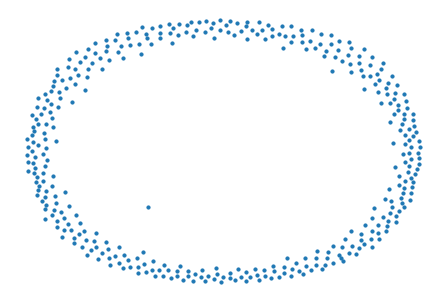

In [ ]:
#Goal: Build a directed network to understand:
    #relations between characters
    #the network itself (type by degree: random? scale-free? GCC?)
#Strategy:
    #Read the CSV file that has the data into a dataframe
    #Build an unconnected network; nodes are the characters with their attributes
    #Discard isolated nodes
    #Add the directed edges to the network
    #Extract GCCs
    #Analyze the network's degree 
    #Analyze type using the powerlaw function

#Build network (no links)
path="./files/characters_with_attributes.csv"
attributes = [
    "Name",
    "Race", 
    "Gender",
    "Occupation", 
    "Affiliation", 
    "Age"
]


df = get_df(path, attributes)
G = nx.DiGraph()
for index, row in df.iterrows():
    name,race,gender, occupation, affiliation, age = row
    G.add_node(name, Race=race, Gender=gender, Occupation=occupation, Affiliation=affiliation, Age=age)
#unconnected network
nx.draw(G, node_size=10)

In [ ]:
#Extract directed edges and add to the network

#Regex patterns with examples
link_pat1 = r"\[{1,}([^:#\(]*?)(?:\]{1,}|\|)" #[[Gaius van Baelsar]] and [[Ifrit (Final Fantasy XIV)|Ifrit]] (before |)
link_pat2 = r"\[{1,}[^:=]*?\|(.*?)\]{1,}"      #[[Ifrit (Final Fantasy XIV)|Ifrit]] (after |)

for node in G.nodes:
    with open("./files/ff14_chars_json/"+node+".txt", "r", encoding="utf-8") as f:
        node_desc = f.read()
        #Set is used to avoid duplicated edge per character (we don't use weighted edges in this course)
        link1 = set(re.findall(link_pat1, node_desc))
        link2 = set(re.findall(link_pat2, node_desc))
        total_links = link1 | link2
        
        for link in total_links:
            if (link in G.nodes) and link != node:#Only add valid links, and discard self-references
                G.add_edge(node, link) #Form the link between the nodes

Number of nodes(Before discarding): 385
Number of edges(Before discarding): 1479
Number of nodes(After discarding): 335
Number of edges(After discarding): 1479


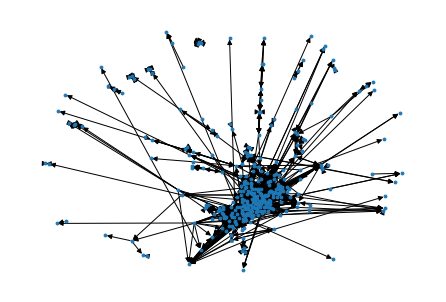

In [ ]:
#Stats before discarding:
print("Number of nodes(Before discarding):", G.number_of_nodes())
print("Number of edges(Before discarding):", G.number_of_edges())

#Discard isolated nodes:
G.remove_nodes_from(list(nx.isolates(G)))

# #Stats after discarding:
print("Number of nodes(After discarding):", G.number_of_nodes())
print("Number of edges(After discarding):", G.number_of_edges()) #edge_before == edges_after --> used to check for errors

#Directed network
nx.draw(G, node_size=8)

In [ ]:
# Extracting the GCC
gcc = max(nx.weakly_connected_components(G), key=len)
gcc = G.subgraph(gcc)

print("There are {} nodes in the network.".format(len(gcc.nodes)))
print("There are {} links in the network.".format(len(gcc.edges())))

There are 320 nodes in the network.
There are 1456 links in the network.


In [ ]:
#Network analysis: most connected characters (in & out)
in_most_connected = sorted(gcc.in_degree,key=lambda x:x[1], reverse=True)[0]
out_most_connected = sorted(gcc.out_degree,key=lambda x:x[1], reverse=True)[0]

print("Most connected character (in-degrees):", in_most_connected)
print("Most connected character (out-degrees):", out_most_connected)

n=5

in_most_connected_ally = sorted(gcc.in_degree,key=lambda x:x[1], reverse=True)[:n]
out_most_connected_ally = sorted(gcc.out_degree,key=lambda x:x[1], reverse=True)[:n]

print(f"Most connected {n} characters (In degree):", in_most_connected_ally, "\n")
print(f"Most connected {n} characters (Out degree):", out_most_connected_ally, "\n")

Most connected character (in-degrees): ('Alphinaud Leveilleur', 57)
Most connected character (out-degrees): ('Alphinaud Leveilleur', 33)
Most connected 5 characters (In degree): [('Alphinaud Leveilleur', 57), ('Gaius van Baelsar', 37), ("Y'shtola Rhul", 35), ('Thancred Waters', 34), ('Zenos yae Galvus', 34)] 

Most connected 5 characters (Out degree): [('Alphinaud Leveilleur', 33), ('Lyse Hext', 30), ("Y'shtola Rhul", 26), ('Elidibus (Final Fantasy XIV)', 25), ('Thancred Waters', 22)] 



Average Degree (in-degree): 4.55


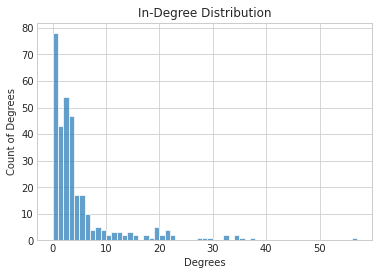

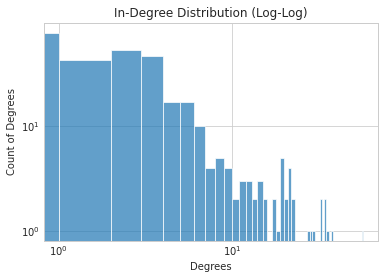

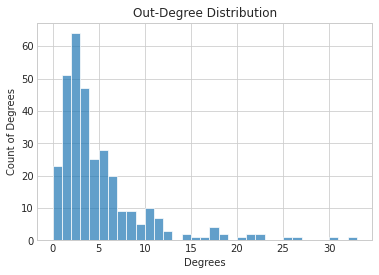

In [ ]:
#Plot degree distribution
def plot_degree_dist(g,in_degree=None,scale=None, title="Degree Distribution"):
    if in_degree == True:
        degrees = sorted([d for n, d in g.in_degree()], reverse=True)
    elif in_degree == False:
        degrees = sorted([d for n, d in g.out_degree()], reverse=True)
    elif in_degree == None:
        degrees = sorted([d for n, d in g.degree()], reverse=True)
    plt.hist(degrees, bins=max(degrees), width = 1, edgecolor = "white", alpha =0.7)
    plt.title(title)
    if scale=="log":
        plt.xscale("log")
        plt.yscale("log")
        plt.title(title + " (Log-Log)")
    plt.xlabel("Degrees")
    plt.ylabel("Count of Degrees")
    plt.show()
print(f"Average Degree (in-degree): {sum(n for _,n in gcc.in_degree())/len(gcc.in_degree)}")
plot_degree_dist(gcc, in_degree=True, scale=None, title="In-Degree Distribution")
plot_degree_dist(gcc, in_degree=True, scale="log", title="In-Degree Distribution")
plot_degree_dist(gcc, in_degree=False, scale=None, title="Out-Degree Distribution")

The in-degree distribution appears to follow a power law distribution, indicating a scale-free network (real network). The out-degree distribution however is less skewed to the right, and is more difficult to interpret. 

We use the powerlaw function below to fit a power distribution and get the gamma values for further analysis.

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


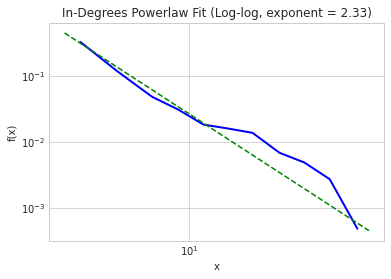

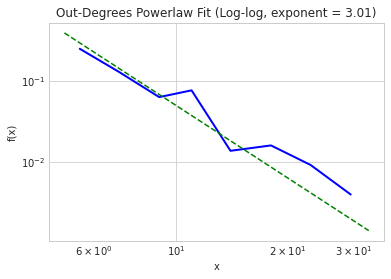

In [ ]:
degrees_in =  sorted([d for n, d in gcc.in_degree()], reverse=True)
degrees_out = sorted([d for n, d in gcc.out_degree()], reverse=True)

fit_in  = powerlaw.Fit(degrees_in)
fit_out = powerlaw.Fit(degrees_out)

gamma_in = fit_in.alpha
gamma_out = fit_out.alpha

fig2 = fit_in.plot_pdf(color='b', linewidth=2)
plt.title(f"In-Degrees Powerlaw Fit (Log-log, exponent = {gamma_in:.2f})")
fit_in.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

fig3 = fit_out.plot_pdf(color='b', linewidth=2)
plt.title(f"Out-Degrees Powerlaw Fit (Log-log, exponent = {gamma_out:.2f})")
fit_out.power_law.plot_pdf(color='g', linestyle='--', ax=fig3)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

For the in-degree distribution, we see that the exponent value ($\gamma = 2.33$) indicates that the network is in the scale-free regime (ultra-small world). 
As for the out-degree distribution, the exponent is almost equal to the critical value of 3 ($ \gamma = 3.01$.). While this makes the out-degree distribution more random-like, it is still not the same as a random network, for the value indicate the presence of a double logarithmic correction $lnlnN$ which *shrinks the distances of this network relative to a random network*.

We will compare our network below to a random one of the same probability.

In [ ]:
#Change the network from directed to undirected
gcc_undir = nx.DiGraph.to_undirected(gcc)
print(f"Average Degree (undirected): {sum(n for _,n in gcc_undir.degree())/len(gcc_undir)}")
# We set n and k
n = len(gcc_undir.nodes())
k = (2*len(gcc_undir.edges()))/n
p = k/(n-1)

#Create the undirected random network
G_r = nx.gnp_random_graph(n = n, p = p, seed = 42)
print("Number of edges in UNDIRECTED network:", len(gcc_undir.edges()))


Average Degree (undirected): 7.1
Number of edges in UNDIRECTED network: 1136


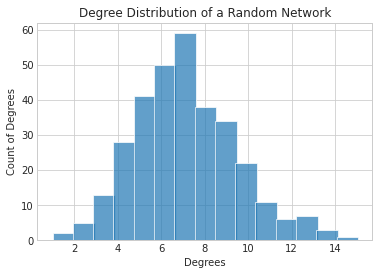

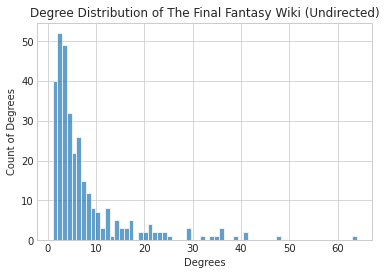

In [ ]:
plot_degree_dist(G_r, title="Degree Distribution of a Random Network")
plot_degree_dist(gcc_undir, title="Degree Distribution of The Final Fantasy Wiki (Undirected)")

100%|██████████| 2000/2000 [00:07<00:00, 285.17it/s]
BarnesHut Approximation  took  2.24  seconds
Repulsion forces  took  3.40  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  0.31  seconds


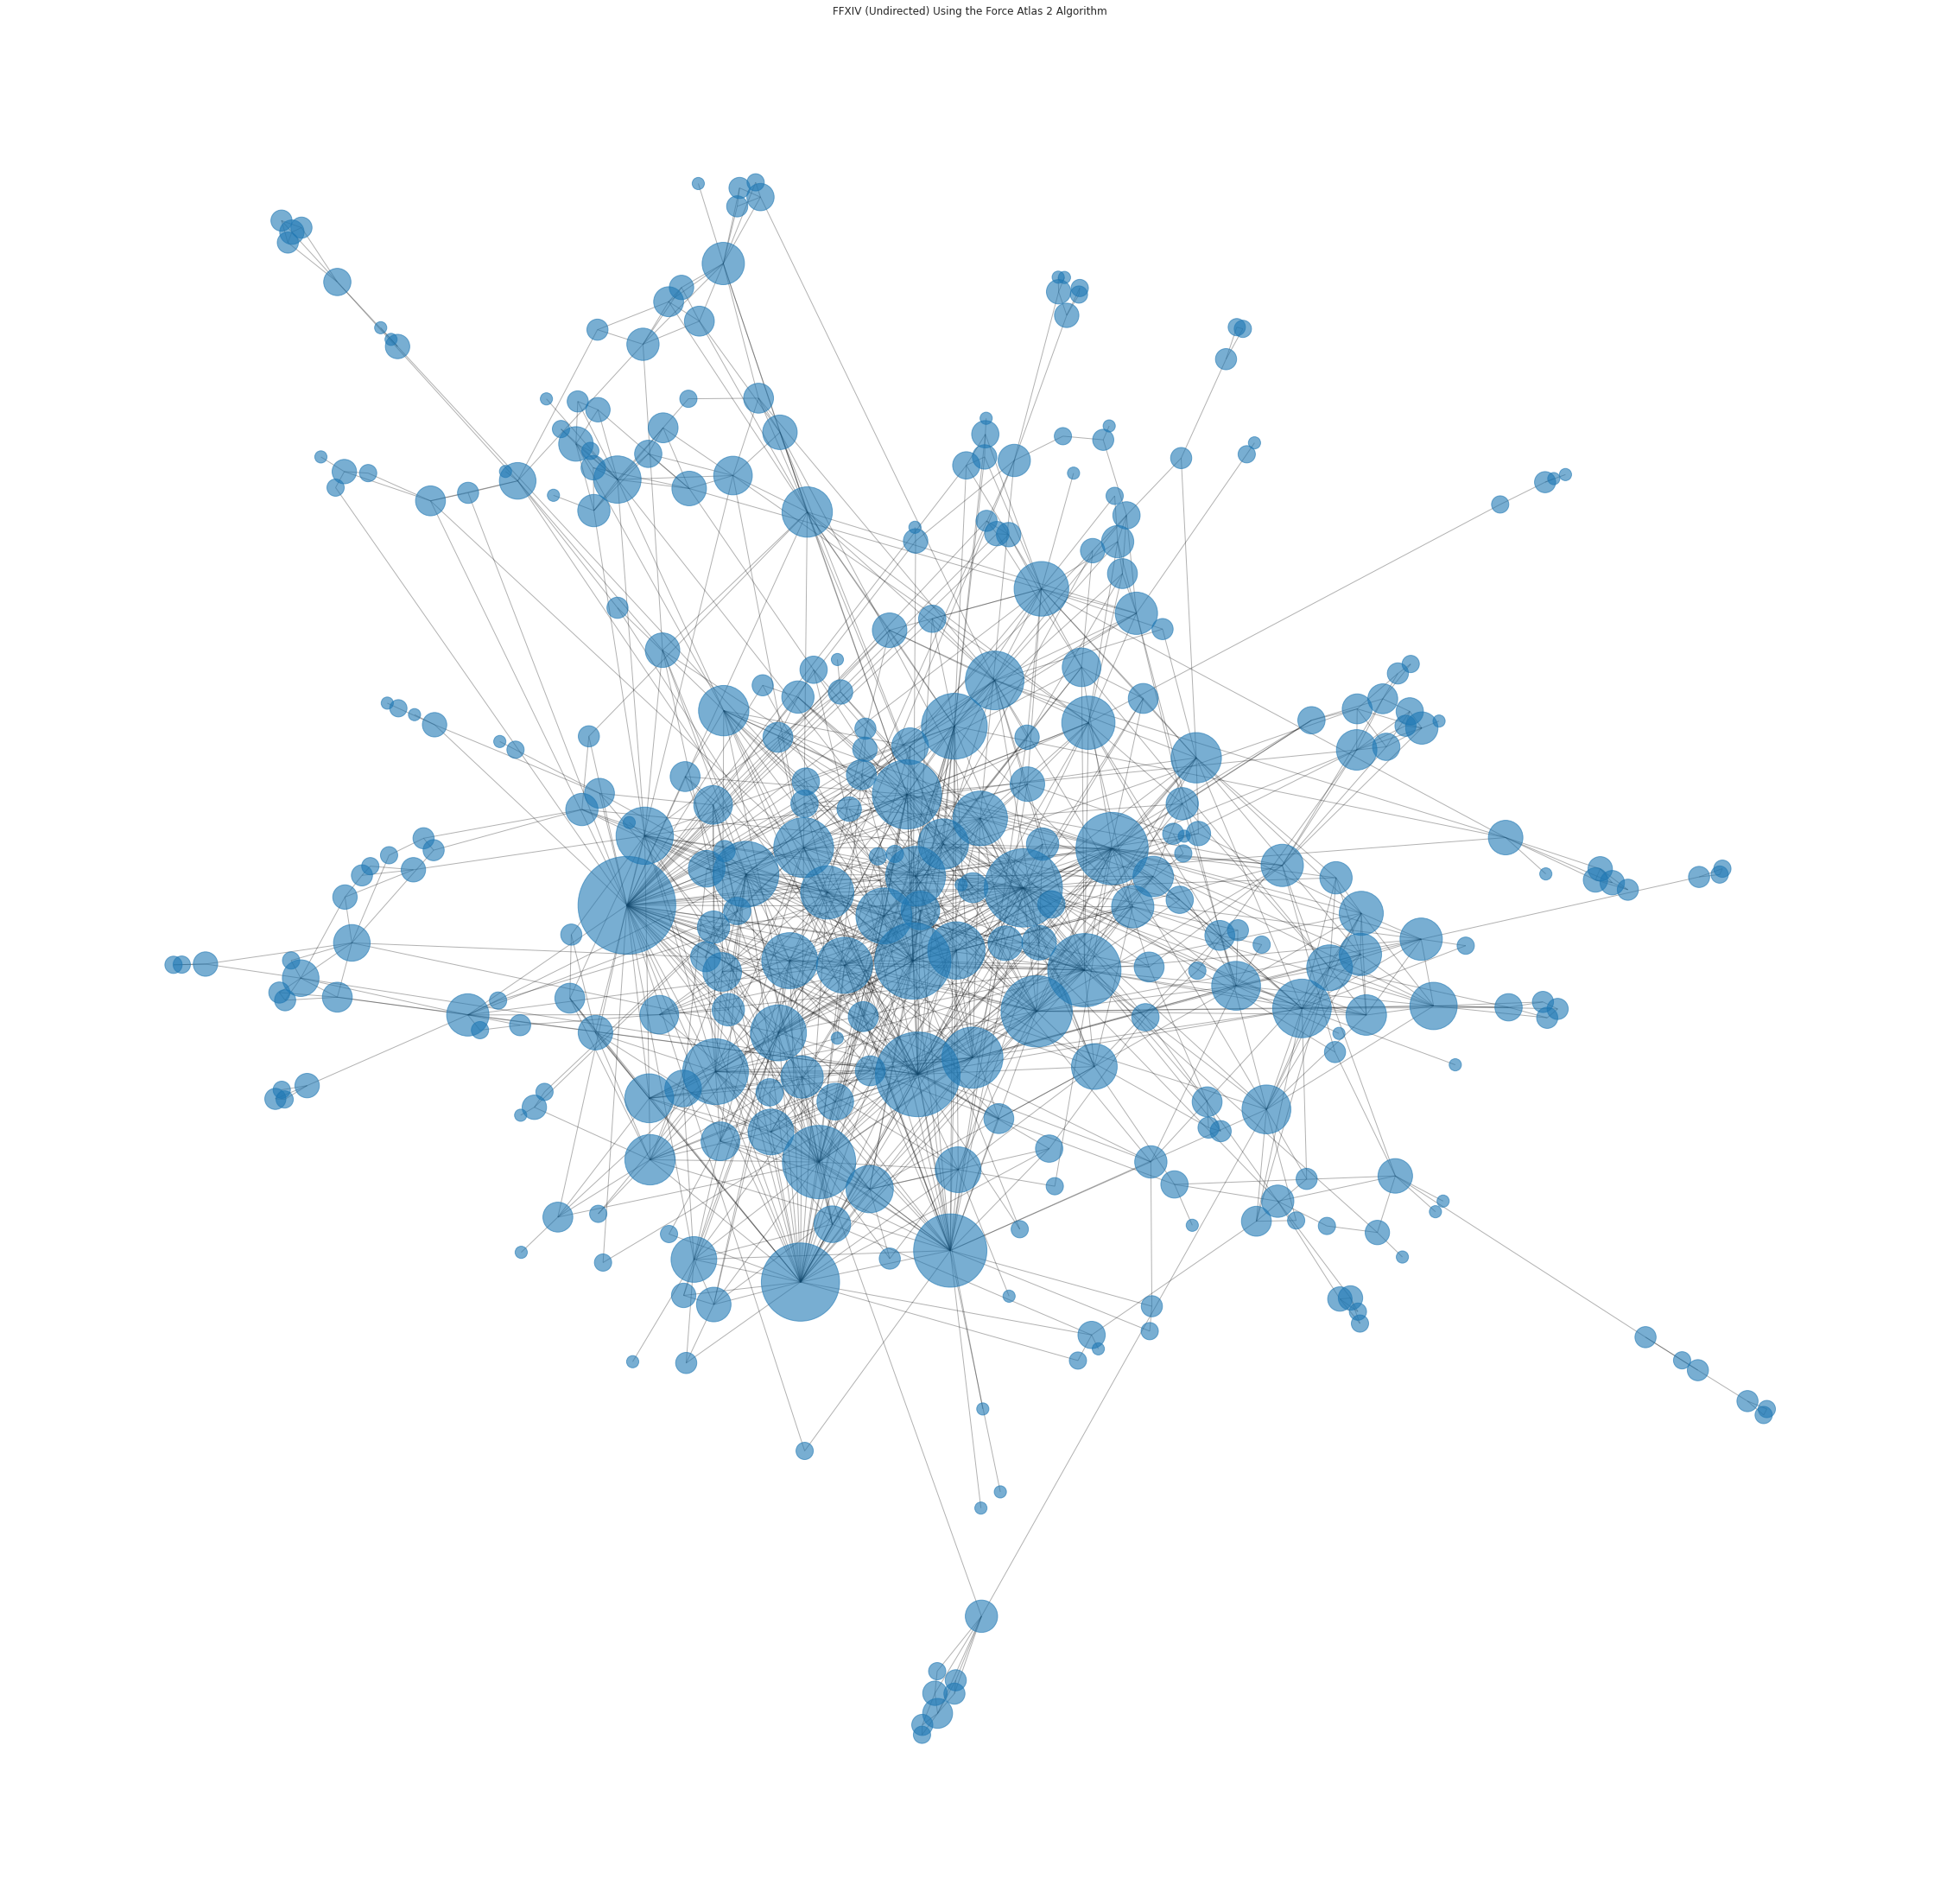

In [ ]:
#Graphing the network using ForceAtlas2
#Create the array of sizes based on the degree in G2
size_list = [x[1]*200 for x in list(gcc_undir.degree())]
forceatlas2 = ForceAtlas2(edgeWeightInfluence=2,  scalingRatio=2, outboundAttractionDistribution=True, strongGravityMode=False, gravity=5.0)
positions = forceatlas2.forceatlas2_networkx_layout(gcc_undir, pos=None, iterations=2000)
plt.figure(figsize=(40,40))
nx.draw_networkx_nodes(gcc_undir, positions, node_size=size_list, alpha=0.6)
nx.draw_networkx_edges(gcc_undir, positions, alpha=0.3)
plt.title("FFXIV (Undirected) Using the Force Atlas 2 Algorithm")
plt.axis('off')
plt.show()

# Data preparation

### Text processing: tokenization, lemmatization etc

Preprocessing the Final Fantasy text. Follow the bullets below for each character in the list:

In [ ]:
path_headers = r'=+[^=].*=+.*'  # Clean headers
path_para = r'\(.*?\)'    # Clean other characters names
link_pat1 = r'\(\w+\)'
link_pat2 = r'\[\w+\]'
link_pat3 = r'\{\w+\}'

# ---- Checkpoint 2: characters_with_attributes.csv

The following code import the csv with the characters and they attributes and create a new dataframe (and csv) containing the threated text descriptions of every character. 

In [ ]:
#Read the file containing the character's page description.
df_clean = pd.read_csv('./files/characters_with_attributes.csv')
df_characters = df_clean['Name']
character_list = df_characters.values
path = './files/ff14_chars_json/'
output_path = './files/ff14_chars_txt_lemmatize/'
txt_list = []
# Create a new column Txt to contain the processed text from each character
# df_clean['Txt'] = ""
all_files = os.listdir(path)
videogame_related_words = ['sideicon','infobox','prime','ffxiv','fftcg','displaytitle','xiv','png','jpg','ffiv']
for char in df_characters:
    with open(path+char+'.txt', 'r', encoding='utf-8') as fd:
        lines = fd.readlines()
        lines_cln = "".join(lines)
        lines_cln = re.sub(link_pat1, "", lines_cln)
        lines_cln = re.sub(link_pat2, "", lines_cln)
        lines_cln = re.sub(link_pat3, "", lines_cln)

        lines_cln = re.sub(path_headers, "", lines_cln) # it is possible to further clean the text
        
        #Tokenize your text with WordPunctTokenizer()
        tokens = WordPunctTokenizer().tokenize(lines_cln)
        #Set everything to lower case.
        tokens = [word.lower() for word in tokens]
        # Exclude punctuation and stop words.
        tokens = [word for word in tokens if word not in set(stopwords.words("english"))]
        tokens = [word for word in tokens if word.isalnum()]
        #Exclude characters names (since we're interested in the words, not the names)
        tokens = [word for word in tokens if word not in character_list]
        #Exclude words related to the videogame, not the characters (since we're interested in the words, not the names)
        tokens = [word for word in tokens if word not in videogame_related_words]
        #Lemmatize your words with WordNetLemmatizer()
        wnl = nltk.WordNetLemmatizer()
        tokens = [wnl.lemmatize(word) for word in tokens]
        # Save plain text in df_clean
        tokens_txt = " ".join(tokens)
        #df_clean.loc[df_clean['Name'] == char, ['Txt']] = tokens_txt
        txt_list.append(tokens_txt)
        # Save plain text in txt file
        with open(output_path+char+".txt", "w", encoding="utf-8") as fo:
            fo.write(tokens_txt)
df_clean['Txt'] = txt_list
df_clean.to_csv('./files/characters_with_attributes_txt.csv')

**Comments**
- Now df_clean contains the lemmatized text in the column 'Txt'. 
- The file folder contains the ff14_txt_lemmatized folder with all .txt files with the lemmatized texts. 
- The csv file 'characters_with_attributes_txt.csv' contains all the information gathered up to this moment.
- Further information related to the videogame and not the character has been eliminated ('sidecon', 'ffiv' for example).

# ------ Checkpoint 3: characters_with_attributes_txt.csv

In [ ]:
df_clean = pd.read_csv('./files/characters_with_attributes_txt.csv')
df_clean[272:280]

,Unnamed: 0,Unnamed: 0.1,Name,Race,Gender,Occupation,Affiliation,Age,Txt
272,272,272,"Almet, Cymet, and Uimet",Viera,Female,Unknown,Unknown,Unknown,character name almet cymet uimet release japan...
273,273,273,Ciuna and Phyna,Viera,Female,Unknown,Fanow,Unknown,character name ciuna phyna release japanese シュ...
274,274,274,Quinfort,Au Ra,Male,Unknown,Night's Blessed,Unknown,character name quinfort release japanese キンフォー...
275,275,275,Valan,Hyur,Male,Unknown,Night's Blessed,Unknown,character name valan release japanese ヴァラン rom...
276,276,276,Xande (Final Fantasy XIV),Unknown,Male,Emperor,Allagan Empire,Unknown,xande final fantasy character name xande relea...
277,277,277,Doga (Final Fantasy XIV),Hyur,Male,Unknown,Allagan Empire,Unknown,doga final fantasy character name doga release...
278,278,278,Unei (Final Fantasy XIV),Hyur,Female,Unknown,Allagan Empire,Unknown,unei final fantasy character name unei release...
279,279,279,Amon (Final Fantasy XIV),Unknown,Male,Unknown,Allagan Empire,Unknown,amon final fantasy character name amon release...


In [ ]:
path_lemmatized = './files/ff14_chars_txt_lemmatize/'
# Use the funciton PlaintextCorpusReader from nltk.corpus to create the FFIXwiki corpus 
ffiv_wiki = PlaintextCorpusReader(path_lemmatized, ".*", encoding="utf-8")

#Preserve order by passing the list of chars
txts = nltk.Text(ffiv_wiki.words(list(character_list+".txt")))

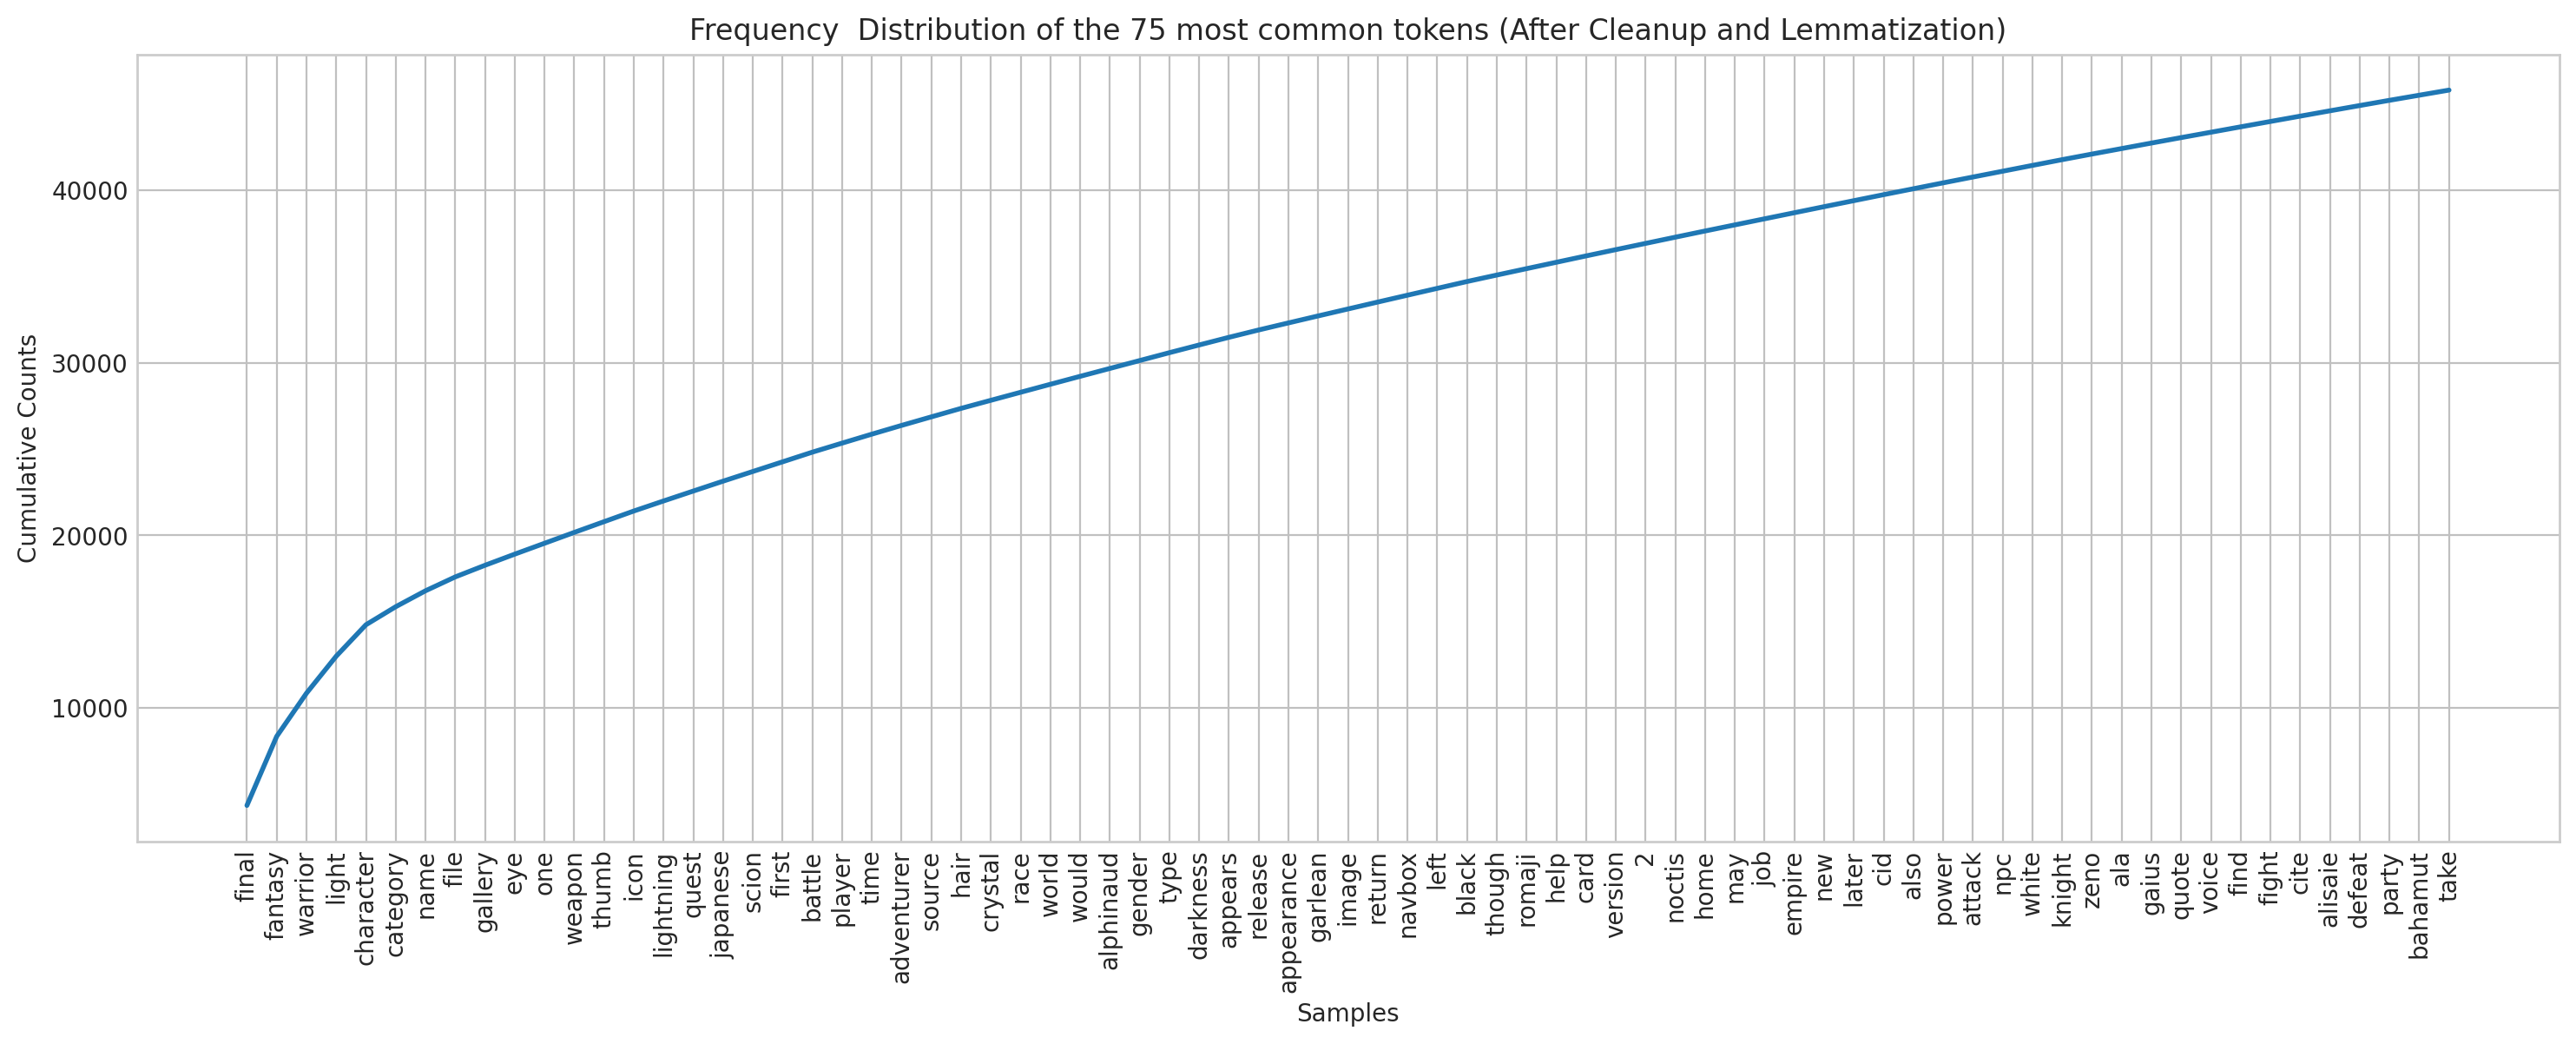

<AxesSubplot:title={'center':'Frequency  Distribution of the 75 most common tokens (After Cleanup and Lemmatization)'}, xlabel='Samples', ylabel='Cumulative Counts'>

In [ ]:
fig = plt.figure(figsize=(18,6), dpi=200)
plt.title("Frequency  Distribution of the 75 most common tokens (After Cleanup and Lemmatization)")
freq_txts = nltk.FreqDist(txts)
freq_txts.plot(75, cumulative=True)

The frequency plot of the most common words is as expected: the two most common words are final fantasy, followed by warrior and light. It is worth mentioning that the main character of the game is named "The Warrior of Light." So the high frequency of these two words is unsurprising.

# PART 2: Word Cloud

**Create a word-cloud for each race of the Greatest Affiliations (i.e. Garlean Empire, High Houses of Ishgard, Doma) according to either TC-IDF. (can also be done with races, but I thought it was better to do something new)**

Apply TF and TF-IDF to all the affiliations

In [ ]:
#Load text for each affiliation into a dictionary {"affiliation" :"full_cleaned_text"}

affiliation_dic = {}
for char in df_clean.Name:
    affiliation = df_clean.loc[df_clean["Name"] == char, "Affiliation"].values[0] #Get the affiliation of the char
    if affiliation in affiliation_dic: #If race exists in the dictionary, append the text
        affiliation_dic[affiliation] += " " + str(df_clean.loc[df_clean["Name"] == char, "Txt"].values[0])
    else: #Otherwise, make a new entry with the text for this affiliation
        affiliation_dic[affiliation] = df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

Get TF values for each word

In [ ]:
counts_dic = {} #TC values
tf_dic = {} #Normalized TC values (TF)
affiliations = df_clean.Affiliation.unique()

for affiliation in affiliations:
    counts = Counter(affiliation_dic[affiliation].split()) #Count the occurance of each word per race to get TC
    counts_dic[affiliation] = counts
    tfs = [(k,v/len(affiliation_dic[affiliation].split())) for k,v in counts.items()] #divide by total number of words per race to get TF
    tf_dic[affiliation] = tfs

Calculate IDF

In [ ]:
N = len(affiliation)
df = {}

#Get all words from the text, irrespective of race
all_words_list = (list(affiliation_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #Remove duplicated words

#Calculate DF first: Check if a word exists in each "document"
for word in all_words:
    for affiliation in affiliations:
        if word in affiliation_dic[affiliation]:
            if word in df:
                df[word]+=1 #max value = number of affiliations = 27
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))

Calculate the most important affiliations:

In [ ]:
Affiliations = {}
Affiliations_keys = set(df_clean['Affiliation'])
for affiliation in Affiliations_keys:
    count = len(df_clean['Affiliation'][df_clean['Affiliation']==affiliation])
    Affiliations[affiliation] = count
del Affiliations['Unknown']
greatest_affiliations = heapq.nlargest(3, Affiliations, key=Affiliations.get)
print('The greatest Affiliations are:\n')
for affiliation in greatest_affiliations:
    print(affiliation, Affiliations[affiliation])

The greatest Affiliations are:

Garlean Empire 16
High Houses of Ishgard 10
Doma 9


Calculate the tc_idf

In [ ]:
#For WordCloud, we need tc_idf
tc_idf = {}
for affiliation in affiliations:
    rslt = []
    for word,counts in counts_dic[affiliation].items():
        tc_idf_word = int(round(counts*idf[word],0)) #Repeat the word by its count
        if tc_idf_word >=0:
            for i in range(tc_idf_word):
                rslt.append(word) #Add the word to a list "count" times
    tc_idf[affiliation]=" ".join(rslt) #Convert to str for the wordcloud library

All the affiliations:

In [ ]:
tc_idf.keys()

dict_keys(['Scions of the Seventh Dawn', 'Circle of Knowing', 'Unknown', 'Students of Baldesion', 'Company of Heroes', 'Garlond Ironworks', 'Omega', 'Garlean Empire', 'Zodiark', 'Amaurot', 'Zenos yae Galvus', 'Ala Mhigan Resistance', 'Garlemald', 'Populares', 'VIIth Imperial Legion', 'Stillglade Fane', "Buscarron's Druthers", 'Greatloam Growery', "Lancers' Guild", "Botanists' Guild", 'Gridania', 'The Raven', "Adventurer's Guild", 'Order of the Twin Adder', "Conjurer's Guild", "Conjurers' Guild", "Miners' Guild", "Gladiators' Guild", 'Immortal Flames', 'Amajina', "Order of Nald'thal", "Pugilists' Guild", 'Eastern Thanalan', 'Sultansworn', 'Alacran', 'The Syndicate', 'Brotherhood of Ash', "Adventurers' Guild", "Eshtaime's Lapidaries", "Weavers' guild", "Goldsmiths' Guild", "Alchemists' Guild", 'Mirage Trust', 'The Defiant', "Marauder's GuildMarauders Guild", "Blacksmiths' Guild", "Kraken's Arms", 'Maelstrom', "Armorers' Guild", "Rogues' Guild", "Arcanists' Guild", 'Sanguine Sirens', 'Kni

Wordcloud of the three most important affiliations:

In [ ]:
# heros = ['Garlean Empire', 'High Houses of Ishgard', 'Doma']
# for affiliation in heros:
#     wc = wordcloud.WordCloud(
#                           background_color='white',
#                           width=1800,
#                           height=1400,
#                           collocations = False
#                          ).generate(tc_idf[affiliation])
#     plt.figure()
#     plt.title(affiliation)
#     plt.imshow(wc)
#     plt.axis('off')
#     plt.show()

In [ ]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [ ]:
plt.figure()
stopwords = set(STOPWORDS)
plt.figure(figsize=[17, 30])

for t in range(len(heros)):
    plt.subplot(5, 2, 2*t+1).set_title(heros[t]+" wordcloud")
    
    mask = np.array(Image.open(heros[t]+".png"))
    transformed_mask = np.ndarray((mask.shape[0],mask.shape[1],mask.shape[2]), np.int32)
    for i in range(len(mask)):
        for j in range(len(mask[i])):
            transformed_mask[i][j] = list(map(transform_format, mask[i][j]))
            
    image_colors = ImageColorGenerator(mask)
    
    wordcloud = WordCloud(max_font_size=130, collocations = False, width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                mask = transformed_mask,
                min_font_size = 10).generate(tc_idf[heros[t]])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")
    plt.subplot(5, 2, 2*t+2).set_title(heros[t])
    plt.imshow(mask, cmap=plt.cm.gray, interpolation='bilinear')
    plt.axis("off")
plt.show()

NameError: name 'heros' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 1224x2160 with 0 Axes>

# Part 3: Finding Communities

In this section we are interested in analyzing the relations amongst the characters. In particular, we want to try to detect communities and study their characteristics. In order to perform this analysis, we are going to apply the Louvain Algorithm for community detection to the undirected network created in the previous sections.

In [ ]:
partition = community_louvain.best_partition(gcc_undir)
print("We found", len(set(partition.values())), "communities")

We found 13 communities


In [ ]:
print("The modularity of the partition is" ,community_louvain.modularity(partition, gcc_undir))

The modularity of the partition is 0.49059973839515975


The modularity value is approximately 0.5, representing a good communities partition.

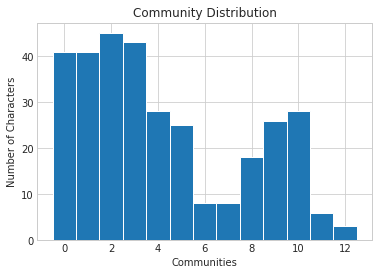

In [ ]:
plt.hist(partition.values(), bins=np.arange(-0.5,len(set(partition.values())), 1), histtype='bar', edgecolor='white')
plt.xlabel("Communities")
plt.ylabel("Number of Characters")
plt.title("Community Distribution")
plt.show()

The algorithm detects 5 small communities that have less than 10 characters, and 9 bigger communities that have between 20 and 50 characters. In the following plot the network is represented with a different color for every community.

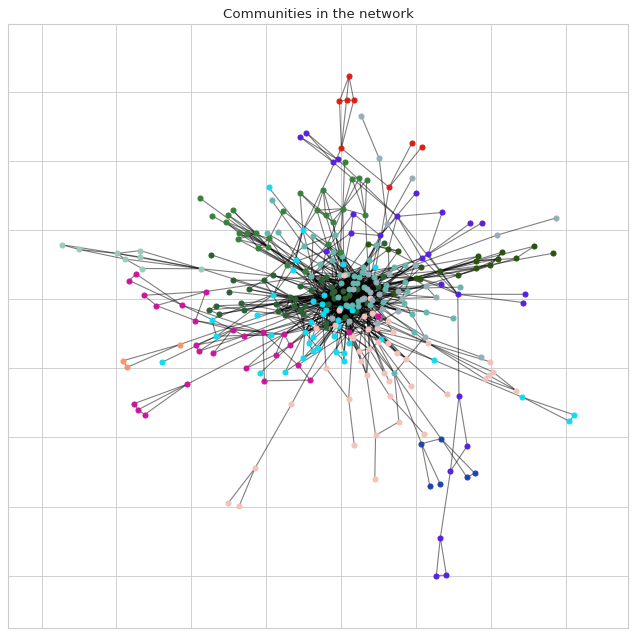

In [ ]:
# Drawing the communities
size = float(len(set(partition.values())))
pos = nx.spring_layout(gcc_undir)
count = 0.
plt.figure(figsize=(10, 10), dpi=80)
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(gcc_undir, pos, list_nodes, node_size = 20, node_color = "#"+''.join(random.choice('0123456789ABCDEF') for j in range(6)))
nx.draw_networkx_edges(gcc_undir, pos, alpha=0.5)
plt.title('Communities in the network')
plt.show()

The characters belonging to the 5 most populous communities have been reported in the following section.

In [ ]:
#Calculate the communities

communities = {}
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    communities[com] = list_nodes
index_list_max = heapq.nlargest(5, communities, key=lambda x:len(communities[x])) # get indexes of 5 largest communities

print("Below, the 5 greatest communitites are represented.\n")

for i in index_list_max:
    print("---> Community ", i)
    print(communities[i]) # -> access the nodes of the 5 biggest communities, TF-IDF can now be applied to each one of them
    print()

Below, the 5 greatest communitites are represented.

---> Community  2
['Alisaie Leveilleur', 'Lyse Hext', 'Papalymo Totolymo', 'Yda Hext', 'Elidibus (Final Fantasy XIV)', 'Fandaniel', 'Varis zos Galvus', 'Zenos yae Galvus', 'Asahi sas Brutus', 'Aulus mal Asina', 'Fordola rem Lupis', 'Grynewaht pyr Arvina', 'Maxima quo Priscus', 'Erik', 'Hamon Holyfist', 'Pipin Tarupin', 'Hilda Ware', 'Conrad Kemp', 'Curtis Hext', 'Gundobald', "M'naago Rahz", 'Meffrid Noward', 'The Griffin', 'Widargelt Beake', 'Hien Rijin', 'Yugiri Mistwalker', 'Gosetsu Daito', 'Yotsuyu goe Brutus', 'Hakuro Gunji', 'Kurobana', 'Tenzen (Final Fantasy XIV)', 'Hancock Fitzgerald', 'Kotokaze Benitoki', 'Kurenai Shisui', 'Cirina Mol', 'Magnai Oronir', 'Sadu Dotharl', 'Lyna', 'Amon (Final Fantasy XIV)', 'Odin (Final Fantasy XIV)', 'Susano (Final Fantasy XIV)', 'Shinryu (Final Fantasy XIV)', 'Tsukuyomi (Final Fantasy XIV)', 'Frixio', 'Unsavory Imp']

---> Community  3
['Estinien Wyrmblood', 'Tataru Taru', 'Biggs and Wedge (Fi

**Results**

The Louvain Algorithm can detect 14 communities in the network and the modularity has a value of 0.5. Since it is not zero or negative, we consider this to be a good theoretical partition. Characters belonging to the same community, are expected to be more connected to each other in the game compared to character belonging to different communities. To prove this point more accurately, it would be necessary to analyze the game more in deep and gather information regarding the actual story behind each character and their true relations with each other in the game. We will not continue this analysis. Instead, we are going to analyze which words are the most representative of each community and finally, we will study the average sentiment of these communities, to understand if there is a common positive or negative feeling among the character of a group.

## Part 5 - Common words in the communities

In this section we are going to identify the most descriptive words related to each community. The objective is to understand if different communities have different related words. We are going to use two different methods: the TF and and the TF-IDF. The first one will take into account how much a specific word appear in the text, while the other will also consider how often that word appear through the whole database, adding value to those words that are more characteristic of a specific community, therefore more relevant. 

To perform the following analyses, we will load the text corresponding to each community into a dictionary: 

{"community_name" :"full_cleaned_text"}.

Each community will be identified by the name of the first character in the community: 

e.i. Community 1 -> 'Alphinaud Leveilleur'.

In [ ]:
community_dic = {}
for community in communities.values():
    name_of_community = community[0]
    for char in community:
        if name_of_community in community_dic:  #If community exists in the dictionary, append the text
            community_dic[name_of_community+'\'s community'] += " " + df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]
        else: #Otherwise, make a new entry with the text for this community
            community_dic[name_of_community+'\'s community'] = df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

Calculate the TF values for each word.

In [ ]:
counts_dic = {} #TC values
tf_dic = {} #Normalized TC values (TF)
community_list = list(community_dic.keys())

for community in community_list:
    counts = Counter(community_dic[community].split()) #Count the occurance of each word per race to get TC
    counts_dic[community] = counts
    tfs = [(k,v/len(community_dic[community].split())) for k,v in counts.items()] #divide by total number of words per race to get TF
    tf_dic[community] = tfs

Calculate the most common words using TF for the top 5 communities.

In [ ]:
tf_dic = {}
counts_dic = {}
top = 5

for community in [community_list[x] for x in index_list_max]:
    counts = Counter(community_dic[community].split())
    counts_dic[community] = counts
    print('---> Community: ', community)
    print(counts.most_common(top)) #print the most common words/race
    tfs = [(k,v/len(community_dic[community].split())) for k,v in counts.items()] #divide by total words/race to get tf
    tf_dic[community] = tfs
    print()

---> Community:  Alisaie Leveilleur's community
[('man', 14), ('woman', 13), ('player', 11), ('hyuran', 10), ('imp', 7)]

---> Community:  Estinien Wyrmblood's community
[('garuda', 27), ('final', 21), ('fantasy', 20), ('messenger', 18), ('xv', 14)]

---> Community:  Warrior of Light (Final Fantasy XIV)'s community
[('yoshida', 42), ('naoki', 34), ('final', 22), ('fantasy', 22), ('april', 16)]

---> Community:  Alphinaud Leveilleur's community
[('ga', 18), ('bu', 18), ('alisaie', 11), ('kobold', 6), ('final', 6)]

---> Community:  Edmont de Fortemps's community
[('marcelloix', 13), ('character', 5), ('final', 4), ('fantasy', 4), ('ehll', 4)]



Calculate the most common words using TF-IDF for the top 5 communities.

In [ ]:
N = len(index_list_max)
df = {}
all_words_list = (list(community_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #look-up only unique words in the corpus

for word in all_words:
    for community in [community_list[x] for x in index_list_max]:
        if word in community_dic[community]:
            if word in df:
                df[word]+=1
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))
tf_idf = {}

for community in [community_list[x] for x in index_list_max]:
    rslt = []
    for word,tf in tf_dic[community]:
        rslt.append((word,tf*idf[word]))
    rslt.sort(key=lambda x:x[1],reverse=True)
    tf_idf[community] = rslt
    

#Highest 5 tf-idf values for each community
for community in tf_idf:
    print("---> Community: ", community)
    print(tf_idf[community][:top])
    print()

---> Community:  Alisaie Leveilleur's community
[('woman', 0.025561758614515057), ('hyuran', 0.019662891241934658), ('imp', 0.01376402386935426), ('unsavory', 0.011797734745160795), ('nero', 0.011797734745160795)]

---> Community:  Estinien Wyrmblood's community
[('garuda', 0.03616937099503244), ('messenger', 0.02411291399668829), ('wind', 0.010716850665194797), ('xv', 0.01045549522328051), ('statue', 0.009377244332045447)]

---> Community:  Warrior of Light (Final Fantasy XIV)'s community
[('yoshida', 0.08000875413454162), ('naoki', 0.06476899144224797), ('april', 0.030479525384587283), ('fool', 0.030479525384587283), ('director', 0.01904970336536705)]

---> Community:  Alphinaud Leveilleur's community
[('alisaie', 0.02659419010716545), ('kobold', 0.014505921876635701), ('titan', 0.01208826823052975), ('warrior', 0.01208826823052975), ('bu', 0.01059784676426326)]

---> Community:  Edmont de Fortemps's community
[('marcelloix', 0.07219260311735767), ('ehll', 0.02221310865149467), ('fra

**Results:**
It appear clear how the TF-IDF analysis gives more interesting results in identifying the most relevant words of a community, by eliminating recurring words as 'fantasy', 'player' and 'final' that are clearly related to the game itself, and thus very common in all the communities. We can also see from the results that the second method does not ever return the same word for different communities, as it happen in the TF analysis, confirming that the TF-IDF is more accurate in detecting the relevant words in a community.

## Part 6 - Sentiment Analysis

We now proceed performing a sentiment analysis of the communities, after we gather the adequate text information related to the story of the characters. 

We are going to perform different analyses. Firstly, we are going to use the LabMT dataset, to calculate the sentiment of each token, created from the textual description of the characters obtained from the wikipages, after proper tokenization and lemmatization. Subsequently, we are going to repeat the same process, this time using the text obtained from written dialogues extracted from the game. This second analysis is expected to return a better understanding of the sentiment of the characters, since it will contain more textual information related to the feelings and sentiments of the characters during the game. 

Lastly, we will use the VADER sentiment analysis tool, applied on the dialogues text. This method will also take into account different aspects of the speeches, like the use of punctuation, capital letters and specific expressions.

Importing the LabMT database.

In [ ]:
import pandas as pd
df = pd.read_csv('./files/Data_Set_S1.txt', delimiter = "\t")
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [ ]:
def sentiment_calculator_LabMT(tokens):
    sumy=0
    length=0
    for token in tokens:
        if token in df['word'].values:
            sumy = sumy + float(df.happiness_average[df.word==token])
            length = length + 1
    return sumy/length

Calculate the sentiment of each community and fill a dictionary with the results: 

i.e.: sentiment_community_dict = {Community: sentiment_value}

**Sentiment Analysis 1**

Data: Text description from the Wikipages

Method: LabMT

In [ ]:
sentiment_community_dict = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in communities[i]:
        tokenized_sentence = lemmatizer.lemmatize(str(df_clean.Txt[df_clean['Name']==char]))  #lemmatize the sentence
        tokenized_sentence = word_tokenize(tokenized_sentence)  # tokenize the sentence
        tokenized_sentence = [token.lower() for token in tokenized_sentence] # set to lower case the sentence
        sumy += sentiment_calculator_LabMT(tokenized_sentence)
        length += 1 #calculate average of the sentences of this character
    sentiment_community_dict[communities[i][0]] = sumy/length

In [ ]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Alisaie Leveilleur': 5.687919576719575,
 'Estinien Wyrmblood': 5.665917497231449,
 'Warrior of Light (Final Fantasy XIV)': 5.673235385210995,
 'Alphinaud Leveilleur': 5.684051490514904,
 'Edmont de Fortemps': 5.611190476190475}

The distribution of the sentiment through the 5 greatest communities is shown below.

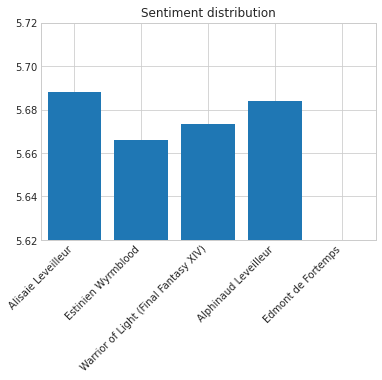

In [ ]:
plt.bar(sentiment_community_dict.keys(), sentiment_community_dict.values())
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, 5.62, 5.72])
plt.title('Sentiment distribution')
plt.show()

All values are just above 5, showing that there is a slight positive sentiment, althogh since the text used for this analysis was collected from the descriptions of the characters, the information they carry about feelings and sentiments of the characters is quite poor, hence the result is expected. We now repeat the analysis with a more relevant database: written dialogues from the videogame.

**Sentiment Analysis 2**

Data: Dialogues from the Videogame

Method: LabMT

In [ ]:
filename = './files/Dialogue Collection.txt'
  
# dictionary where the lines from the text will be stored
dict1 = {}

# creating dictionary
with open(filename, encoding="UTF-8") as f:
    lines = (line.rstrip() for line in f) # All lines including the blank ones
    lines = (line for line in lines if line) # Non-blank lines

    for line in lines:
        if ':' in line:
#             print(line)
            # reads each line and trims of extra the spaces 
            # and gives only the valid words
            command, description = line.strip().split(':', 1) # split the line at the :
            if command in dict1.keys():
                dict1[command] += "".join(description)   # fill the dict1 -> {char: Dialogue}
            else: 
                dict1[command] = description

The file containing the character's dialogues only has first names, not surnames or complete names. Also, not all characters are in the dialogues. To solve the problem of the uncompleted names, the dictionary keys are replaced with the full name of the character (when it is possible to identify the character).

In [ ]:
names = df_clean['Name'].values
keys = list(dict1.keys())
for name in names:
    for key in keys:
        if key == name.split()[0]:
            dict1[name] = dict1[key]

The following list contains the characters who were identified in the dialogues.

In [ ]:
list(x for x in dict1.keys() if x in names)

['Janremi Blackheart',
 'Eline Roaille',
 'Mutamix Bubblypots',
 "F'hobhas",
 'Lahabrea',
 'Frixio',
 'Gundobald',
 "R'ashaht Rhiki",
 'Brayflox Alltalks',
 'Iliud',
 'Forlemort',
 'Gaius van Baelsar',
 'Pashtarot',
 'Igeyorhm',
 'Nabriales',
 'Alphinaud Leveilleur',
 'Alisaie Leveilleur',
 "Y'shtola Rhul",
 'Thancred Waters',
 'Urianger Augurelt',
 'Minfilia Warde',
 'Papalymo Totolymo',
 'Yda Hext',
 'Tataru Taru',
 'Arenvald Lentinus',
 'Riol Forrest',
 'Cid Garlond',
 'Biggs and Wedge (Final Fantasy XIV)',
 'Buscarron Stacks',
 'Momodi Modi',
 'Serendipity (Final Fantasy XIV)',
 'Baderon Tenfingers',
 "H'naanza Esi",
 'Haurchefant Greystone',
 'Drillemont de Lasserrant',
 'Meffrid Noward',
 'Ifrit (Final Fantasy XIV)',
 'Titan (Final Fantasy XIV)',
 'Garuda (Final Fantasy XIV)',
 'Edda Pureheart',
 'Garuda (Final Fantasy XV boss)',
 'Garuda (Final Fantasy XV summon)']

The dialogues do not contain all the characters from the game, even though we checked that each community must have at least several characters found in the dialogues. For this reason the sentiment analysis using this dataset will be an approximation of the real sentiment. It would be necessary to gather more dialogues from the game to get a more accurate result. For the scope of this project, we will continue anyway using this dialogues, analyzing the sentiment of each characters and then calculate the average sentiment of the communities.

In [ ]:
def sentiment_calculator_LabMT(tokens):
    sumy=0
    length=0
    for token in tokens:
        if token in df['word'].values:
            sumy += float(df.happiness_average[df.word==token])
            length += 1
    return sumy/length

In [ ]:
sentiment_community_dict = {}
sentiment_community_all = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in communities[i]:
        if char in list(dict1.keys()):
            # print('Community:',communities[i][0], '---> Character dialogue found:', char)
            #Tokenize your text with WordPunctTokenizer()
            tokens = WordPunctTokenizer().tokenize(dict1[char])
            # Exclude punctuation and stop words.
            tokens = [word for word in tokens if word.isalnum()]
            #Set everything to lower case.
            tokens = [word.lower() for word in tokens]
            #Lemmatize your words with WordNetLemmatizer()
            wnl = nltk.WordNetLemmatizer()
            tokens = [wnl.lemmatize(word) for word in tokens]
            tmp_value = sentiment_calculator_LabMT(tokens)
            sumy += tmp_value
            length += 1 #calculate average of the sentences of this character
            if communities[i][0] in list(sentiment_community_all.keys()):
                sentiment_community_all[communities[i][0]].append(tmp_value)
            else:
                sentiment_community_all[communities[i][0]] = [] 
                sentiment_community_all[communities[i][0]].append(tmp_value)
    sentiment_community_dict[communities[i][0]] = sumy/length

ZeroDivisionError: division by zero

In [ ]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Alphinaud Leveilleur': 5.376597378069641,
 'Alisaie Leveilleur': 5.38555038513152,
 "Y'shtola Rhul": 5.374735237554884,
 'Warrior of Light (Final Fantasy XIV)': 5.381406712565082,
 'Jessie Jaye': 5.5525563063063075}

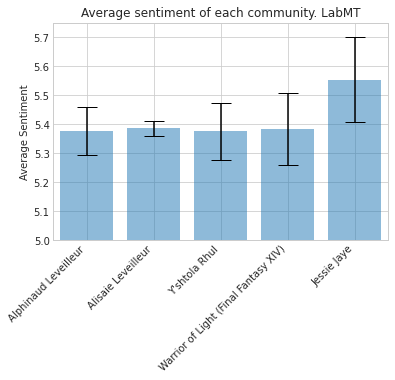

In [ ]:
# Plot the results
communities_names = sentiment_community_all.keys()
x_pos = communities_names
CTEs = [np.mean(x) for x in sentiment_community_all.values()]
error = [np.std(x) for x in sentiment_community_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, 5, 5.75])
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. LabMT')
plt.show()

As a result, all values are all between the value 5 and 6, meaning there is a slight positive average sentiment in all communities. The error bars do not show a great variance in the values, meaning that the character in every community take all similar values. We now proceed with the VADER analysis, using the Dialogue dataset.

**Sentiment Analysis 3**

Data: Dialogues from the Videogame

Method: VADER

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_community_dict = {}
sentiment_community_all = {}
lemmatizer = WordNetLemmatizer()
for i in index_list_max:
    sumy = 0 
    length = 0
    for char in list(communities[i]):
        if char in list(dict1.keys()):
            # print('Community:',communities[i][0], '---> Character dialogue found:', char)        
            vs = analyzer.polarity_scores(dict1[char])
            sumy += vs['compound']
            length += 1 # calculate average of all the sentences of this character
            if communities[i][0] in list(sentiment_community_all.keys()):
                sentiment_community_all[communities[i][0]].append(vs['compound'])
            else:
                sentiment_community_all[communities[i][0]] = [] 
                sentiment_community_all[communities[i][0]].append(vs['compound'])
    sentiment_community_dict[communities[i][0]] = sumy/length

In [ ]:
print('Average sentiment of the 5 greatest communities:')
sentiment_community_dict

Average sentiment of the 5 greatest communities:


{'Alphinaud Leveilleur': 0.8166666666666668,
 'Alisaie Leveilleur': 0.6967500000000001,
 "Y'shtola Rhul": 0.6476,
 'Warrior of Light (Final Fantasy XIV)': 0.88745,
 'Jessie Jaye': 0.5754}

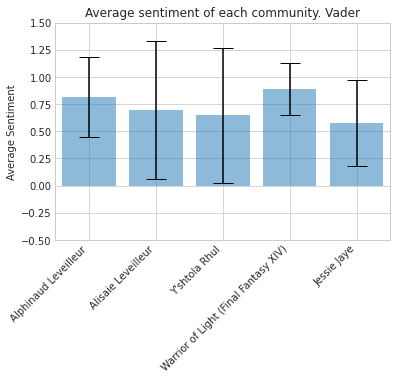

In [ ]:
# Plotting the results
communities_names = sentiment_community_all.keys()
x_pos = communities_names
CTEs = [np.mean(x) for x in sentiment_community_all.values()]
error = [np.std(x) for x in sentiment_community_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha="right")
plt.axis([-0.5, 4.5, -0.5, 1.5])
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. Vader')
plt.show()

The VADER analysis gives more interesting results. All communities scored a value greater than zero, that means the average sentiment is positive, in particular, the *Warrior of Light (Final Fantasy XIV)* 's community, scored 0.869, meaning a great positivity in the text. In this case we can also see from the error bars that there is much more variance in the characters of one community. For example, the *Lyse Hext* 's community scored the positive value 0.636 even though the error bars indicate at least one character got a negative result.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f6f5ff7-c522-4b00-830d-73030439484f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>